In [1]:
%matplotlib widget
import torch
import os
import copy
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

from sphMath.operations import sph_operation, mod
from sphMath.sampling import buildDomainDescription, sampleRegularParticles
from sphMath.modules.eos import idealGasEOS
from sphMath.schema import getSimulationScheme
from sphMath.reference.sod import buildSod_reference, sodInitialState, generateSod1D
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.reference.sod import plotSod
from sphMath.reference.hydrostatic import generateHydroStatic
from sphMath.kernels import KernelType
from sphMath.plotting import visualizeParticles, updatePlot
from sphMath.sampling import buildDomainDescription
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.plotting import visualizeParticles, updatePlot
from sphMath.integration import getIntegrator
from sphMath.util import volumeToSupport
from sphMath.boundary import sampleDomainSDF
from sphMath.kernels import getKernelEnum
from sphMath.sdf import getSDF, sdfFunctions, operatorDict, sampleSDF
from sphMath.regions import buildRegion, filterRegion, plotRegions
from sphMath.modules.timestep import computeTimestep
# from sphMath.schemes.weaklyCompressible import updateBodyParticles, initializeWeaklyCompressibleSimulation
from sphMath.schemes.deltaSPH import deltaPlusSPHScheme, DeltaPlusSPHSystem
from torch.profiler import profile,  ProfilerActivity
from sphMath.integration import IntegrationSchemeType
from sphMath.enums import *

In [23]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
dtype = torch.float32

nx = 100
dim = 2
kernel = KernelType.B7
targetNeighbors = n_h_to_nH(4,dim)
CFL = 0.3
goalRadius = 0.8

gamma = 5/3
rho_low = 1
rho_high = 4
samplingBefore = True

scheme = SimulationScheme.CompSPH
integrationScheme = IntegrationSchemeType.rungeKutta2

viscositySwitch = None
supportScheme = 'Owen'

L = 1
domain = buildDomainDescription(l = L, dim = dim, periodic = True, device = device, dtype = dtype)

simulator, SimulationSystem, solverConfig, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     gamma, targetNeighbors, domain, 
     viscositySwitch=viscositySwitch, supportScheme = supportScheme)
integrationScheme = getIntegrator(integrationScheme)

# config = {
#     'domain': domain,
#     'kernel': wrappedKernel,
#     'targetNeighbors': targetNeighbors,
#     'verletScale': 1.4,
#     'shifting': {'scheme': 'delta', 'freeSurface': False},
#     'surfaceDetection': {'active': False},
#     'pressure':{'term': 'Antuono'},
#     'fluid': {'rho0': 1, 'c_s': 20},    
#     'gravity': {'active': False, 'magnitude': 1, 'mode': 'potential'},
#     'particle': {'nx': nx + 2 * band, 'dx': L/nx, 'targetNeighbors': targetNeighbors, 'band': band},
#     'timestep':{'CFL': CFL, 'dt': 1e-3, 'maxDt': 1e-2, 'minDt': 1e-6}
# }

solverConfig['particle'] = {
     'nx': nx,
     'dx': L/nx,
     'targetNeighbors': targetNeighbors,
     'band': 0
}

In [24]:
area = solverConfig['particle']['dx']**2


True: dxs: [tensor(0.0100, device='cuda:0'), tensor(0.0100, device='cuda:0')], ns: [tensor(100, device='cuda:0', dtype=torch.int32), tensor(100, device='cuda:0', dtype=torch.int32)], nx: 100
True: dxs: [tensor(0.0100, device='cuda:0'), tensor(0.0100, device='cuda:0')], ns: [tensor(100, device='cuda:0', dtype=torch.int32), tensor(100, device='cuda:0', dtype=torch.int32)], nx: 100
Number of Particles:  10000


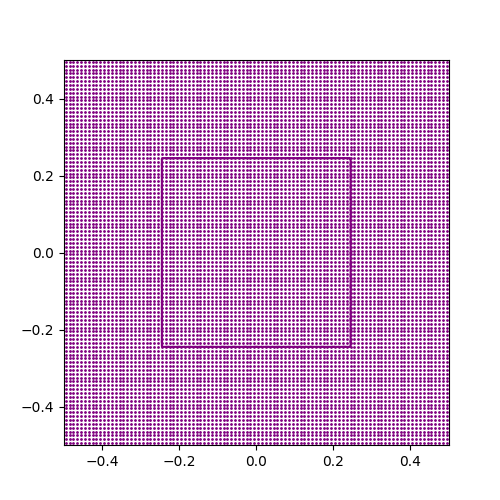

In [25]:
# inner_sdf = lambda points: sampleSDF(points, lambda x: getSDF('box')['function'](x, torch.tensor([1/3,1/3]).to(points.device)))
# inner_sdf_ = lambda x: getSDF('circle')['function'](x, torch.tensor(L/4).to(x.device))
inner_sdf_ = lambda x: getSDF('box')['function'](x, torch.tensor([L/4,L/4]).to(x.device))
inner_sdf = lambda points: sampleSDF(points, inner_sdf_, invert = False)
outer_sdf_ = lambda x: getSDF('box')['function'](x, torch.tensor([L,L]).to(x.device))

outer_sdf_cutaway = operatorDict['difference'](
    outer_sdf_,
    # operatorDict['invert'](inner_sdf_),
    inner_sdf_
    # outer_sdf_
)

outer_sdf = lambda points: sampleSDF(points, outer_sdf_cutaway, invert = False)




# inlet_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([0.125,0.125]).to(points.device)), torch.tensor([-0.5,0.5]).to(points.device)), invert = False)
# outlet_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([0.125,0.125]).to(points.device)), torch.tensor([0.5,-0.5]).to(points.device)), invert = False)
# outletBuffer_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([0.25,0.25]).to(points.device)), torch.tensor([0.5,-0.5]).to(points.device)), invert = False)


regions = []
# config['particle']['shortEdge'] = True
# regions.append(buildRegion(sdf = domain_sdf, config = config, type = 'boundary', kind = 'constant'))
regions.append(buildRegion(sdf = inner_sdf, config = solverConfig, type = 'fluid', initialConditions={'densities': rho_high, 'masses': area * rho_high}))
regions.append(buildRegion(sdf = outer_sdf, config = solverConfig, type = 'fluid', initialConditions={'densities': rho_low, 'masses': area * rho_low}))
# regions.append(buildRegion(sdf = inlet_sdf, config = config, type = 'inlet', dirichletValues={'densities': config['fluid']['rho0'], 'velocities': torch.tensor([1,0], device = device, dtype = dtype)}, updateValues = {'densities': 0, 'velocities': torch.tensor([0,0], device = device, dtype = dtype)}))

# regions.append(buildRegion(sdf = outlet_sdf, config = config, type = 'outlet'))
# regions.append(buildRegion(sdf = outletBuffer_sdf, config = config, type = 'buffer', bufferValues = ['densities', 'velocities', 'pressures']))

# regions.append(buildRegion(sdf = box_sdf, config = config, type = 'dirichlet', dirichletValues={'densities': 2.0, 'velocities': torch.tensor([1,2], device = device, dtype = dtype), 'pressures': lambda x: torch.where(x[:,0] > 0, 0.0, 1.0)}, updateValues = {'densities': 2.0}))


for region in regions:
    region = filterRegion(region, regions)


fig, axis = plt.subplots(1, 1, figsize=(5, 5), squeeze=False)

axis[0,0].set_xlim(-L/2, L/2)
axis[0,0].set_ylim(-L/2, L/2)
axis[0,0].set_aspect('equal', adjustable='box')
    
plotRegions(regions, axis[0,0], plotFluid = True, plotParticles = True)
axis[0,0].set_aspect('equal', adjustable='box')
print('Number of Particles: ', sum([region['particles'].positions.shape[0] for region in regions ]))


In [26]:
from sphMath.schemes.initializers import initializeSimulation, updateBodyParticles

In [31]:
particleState, config, rigidBodies = initializeSimulation(scheme, solverConfig, regions)
particleState.alpha0s = torch.ones_like(particleState.densities)
particleState.divergence = torch.zeros_like(particleState.densities)
particles = copy.deepcopy(particleState)

particleSystem = SimulationSystem(domain, None, 0., copy.deepcopy(particleState), priorStep = None)
for rigidBody in rigidBodies:
    particleState = updateBodyParticles(scheme, particleState, rigidBody)

from sphMath.modules.timestep import computeTimestep
dt = computeTimestep(scheme, 0, particleSystem.systemState, solverConfig, None)

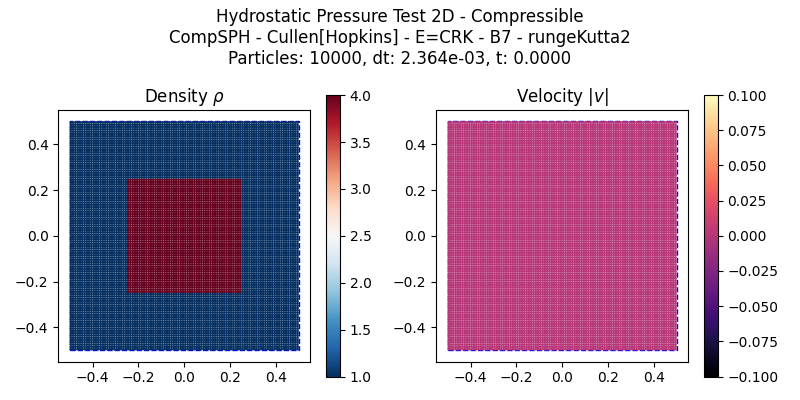

In [32]:
fluidParticles = particleSystem.systemState
fig, axis = plt.subplots(1, 2, figsize = (8, 4), squeeze = False)

markerSize = 1
densityPlotState = visualizeParticles(fig, axis[0,0],
                     particles = fluidParticles, 
                     domain = domain, 
                     quantity = fluidParticles.densities, 
                     which = 'fluid',
                     visualizeBoth=False,
                     kernel = solverConfig['kernel'],
                     plotDomain = True,
                     cmap = 'RdBu_r',
                     title='Density $\\rho$',
                     markerSize = markerSize,)

velocityPlotState = visualizeParticles(fig, axis[0,1],
                     particles = fluidParticles, 
                     domain = domain, 
                     quantity = fluidParticles.velocities, 
                     which = 'fluid',
                     mapping = 'L2',
                     visualizeBoth=False,
                     kernel = solverConfig['kernel'],
                     plotDomain = True,
                     cmap = 'magma',
                     title='Velocity $|v|$',
                     markerSize = markerSize,)

fig.suptitle(f"Hydrostatic Pressure Test 2D - Compressible\n{solverConfig['schemeName']}\nParticles: {fluidParticles.positions.shape[0]}, dt: {dt:1.3e}, t: {particleSystem.t:.4f}", fontsize=12)

fig.tight_layout()

In [ ]:
imagePrefix = './images/Hydrostatic/'
os.makedirs(imagePrefix, exist_ok = True)

fig.savefig(f'{imagePrefix}frame_{0:05d}.png', dpi = 100)

# config['diffusion'] = {'alpha': 0.1}
# dt = computeDT(particleSystem.systemState, CFL = CFL, solverConfig = solverConfig)
# print(dt)
# dt = 1e-4
import math
fps = 50
exportInterval = 1 / fps
exportSteps = int(math.ceil(exportInterval / dt))
newDt = exportInterval / exportSteps
plotInterval = int(math.floor(exportInterval / newDt))
plotInterval = min(max(plotInterval,1), 40)
print(f'Current dt: {dt}')
print(f'Plot Interval: {plotInterval}')
print(f'export Steps: {exportSteps}')
print(f'New dt: {newDt}')

dt = newDt
# print(plotInterval)
# print(dt)

In [34]:
particles = copy.deepcopy(particleState)
particleSystem = SimulationSystem(domain, None, 0., copy.deepcopy(particleState), priorStep = None)
for rigidBody in rigidBodies:
    particleState = updateBodyParticles(scheme, particleState, rigidBody)


t = 0
timeLimit = 10
timesteps = int(timeLimit / dt)
# plotInterval = 50

for i in (tq:=tqdm(range(timesteps))):
    particleSystem, currentState, updates = integrationScheme.function(particleSystem, dt, simulator, config, priorStep = particleSystem.priorStep, verbose = False)
    
    # particleSystem.systemState.velocities = particleSystem.systemState.velocities * 0.99

    if i % plotInterval == plotInterval - 1 or i == timesteps - 1:

        # rhoMin = particleSystem.systemState.densities.min().detach().cpu().item() / config['fluid']['rho0']
        # rhoMean = particleSystem.systemState.densities.mean().detach().cpu().item() / config['fluid']['rho0']
        # rhoMax = particleSystem.systemState.densities.max().detach().cpu().item() / config['fluid']['rho0']

        # kineticEnergy = 0.5 * particleSystem.systemState.masses / config['fluid']['rho0'] * particleSystem.systemState.densities * torch.linalg.norm(particleSystem.systemState.velocities, dim = -1)**2
        # totalInitialEnergy = (initialKineticEnergy).sum().detach().cpu().item()
        # totalEnergy = (kineticEnergy).sum().detach().cpu().item()

        # fig.suptitle(f'Kolmogorov Flow, ptcls = {particleState.positions.shape[0]}, kernel = {kernel}, neighbors = {targetNeighbors:.2g}, CFL = {CFL}\n$\\rho$ = [{rhoMin:.4g} | {rhoMean:.4g} | {rhoMax:.4g}], $E_0$ = {totalInitialEnergy:.4g}, $E$ = {totalEnergy:.4g}, $\\Delta E$ = {totalEnergy - totalInitialEnergy:.4g}, $t$ = {t:.4g}, $\Delta t$ = {dt:.4g}')
        fig.suptitle(f"Hydrostatic Pressure Test 2D - Compressible\n{solverConfig['schemeName']}\nParticles: {fluidParticles.positions.shape[0]}, dt: {dt:1.3e}, t: {particleSystem.t:.4f}", fontsize=12)

        updatePlot(densityPlotState, particleSystem.systemState, particleSystem.systemState.densities)
        updatePlot(velocityPlotState, particleSystem.systemState, particleSystem.systemState.velocities)
        # updatePlot(uidPlot, particleSystem.systemState, particleSystem.systemState.pressures)

        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(f'{imagePrefix}frame_{i:05d}.png', dpi = 100)
    # break
    # if i > 90:
        # break
    

  0%|          | 0/4500 [00:00<?, ?it/s]

In [ ]:
from sphMath.util import postProcess

postProcess(
    imagePrefix = imagePrefix,
    fps = 50,
    exportName = 'hydrostatic_2d_compSPH',
    targetLongEdge = 600
)
# def postProcess(imagePrefix, fps, exportName, targetLongEdge = 600):

Copying video to videos folder
Done!


In [38]:

import os
import subprocess
import shlex
import imageio.v2 as imageio
from skimage.transform import resize, rescale
from skimage.io import imread
def postProcess(imagePrefix, fps, exportName, targetLongEdge = 600):
    fileList = os.listdir(imagePrefix)
    fileList = [f for f in fileList if f.endswith('.png') and f.startswith('frame_')]
    fileList = sorted(fileList)

    writer = imageio.get_writer(f'{imagePrefix}/output.mp4', fps=50, bitrate='10M')
    for image in fileList:
        writer.append_data(imageio.imread(imagePrefix + image))
    writer.close()

    images = []
    for image in fileList:
        images.append(imread(imagePrefix + image))

    currentImageSize = images[0].shape
    currentLongEdge = max(images[0].shape[0], images[0].shape[1])
    ratio = targetLongEdge / currentLongEdge

    images = [(rescale(image, ratio, anti_aliasing=True, channel_axis=-1)*255).astype('uint8') for image in images]

    # for image in images:
        # print(image.shape)
        # break

    # images = [resizeImageLongEdge(i, 600) for i in images]

    imageio.mimsave(f'{imagePrefix}/output.gif', images, fps=50, loop = 0)
    
    print('Copying video to videos folder')
    os.makedirs(f'./videos/', exist_ok= True)
    # subprocess.run(shlex.split(f'cp {imagePrefix}/output.mp4 ./videos/{exportName}.mp4'))
    subprocess.run(shlex.split(f'cp {imagePrefix}/output.gif ./videos/{exportName}.gif'))
    lastFrameFile = imagePrefix + fileList[-1]
    subprocess.run(shlex.split(f'cp {lastFrameFile} ./videos/{exportName}.png'))
    print('Done!')